In [277]:
import pandas as pd

import matplotlib.pyplot as plt

In [278]:
# Import Dataframe data pull
df_pts =pd.read_csv('df_pts.csv', index_col=0)
df_sch = pd.read_csv('df_sch.csv', index_col=0)
df_tm = pd.read_csv('df_tm.csv', index_col=0)
df_tm1 = pd.read_csv('df_tm1.csv', index_col=0)

In [279]:
# Combine Team Data
teams = df_tm.merge(df_tm1)

In [280]:
# Team Owners
tm_owners = teams[['TeamID','Year','First','Last']]

In [281]:
#Combine pts data and owners
total_matchups = df_pts.merge(tm_owners)


In [282]:
# Format - Could skip this step. One of our owners has two users assigned to their team
total_matchups['First'] = total_matchups['First'].str.capitalize()
total_matchups['Last'] = total_matchups['Last'].str.capitalize()

total_matchups.drop_duplicates(inplace=True)

total_matchups['Full Name'] = total_matchups['First'] + " "+ total_matchups['Last']


In [283]:
df_sch['Matchup_ID'] = df_sch['Year'].astype(str) + df_sch['Week'].astype(str)  + df_sch['HomeTeamId'].astype(str) + df_sch['AwayTeamId'].astype(str) 

In [284]:
df_sch_a = df_sch[['Year','Week','Matchup_ID','Type','AwayTeamId']].rename(columns={'AwayTeamId':'TeamID'})
df_sch_h = df_sch[['Year','Week','Matchup_ID','Type','HomeTeamId']].rename(columns={'HomeTeamId':'TeamID'})
df_sch_1 = pd.concat([df_sch_a,df_sch_h])

In [285]:
df_matchups = total_matchups.merge(df_sch_1,how='inner')

In [286]:
df_matchups['Actual_Winner'] = df_matchups.groupby('Matchup_ID')['Apts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['Optimal_Winner'] = df_matchups.groupby('Matchup_ID')['Opts'].transform(lambda x: (x == x.max()).astype(int))
df_matchups['ESPN_Winner'] = df_matchups.groupby('Matchup_ID')['Epts'].transform(lambda x: (x == x.max()).astype(int))

In [287]:
# Random season had second owner. the data is duplicated so I removed this owner.
df_matchups_1 = df_matchups.loc[df_matchups['Full Name']!='Dave Miller']

In [288]:
df_matchups_1['Optimal_Missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Opts']
df_matchups_1['ESPN_missed_Pts'] = df_matchups_1['Apts'] - df_matchups_1['Epts']

/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44747/1951970540.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sj/rsx4zyld6flczf6q6r20b1c80000gn/T/ipykernel_44747/1951970540.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [289]:
# More formatting 
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
df_matchups_1.loc[df_matchups_1['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [290]:
df_sorted = df_matchups_1.sort_values(by=['Matchup_ID', 'TeamID']).reset_index(drop=True)

# Shift the Apts column up and down to align with the opponent's values
df_sorted['Opponent_Apts'] = df_sorted['Apts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Apts'] = df_sorted['Apts'].shift(1)

df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

#df_sorted['Opponent_Opts'] = df_sorted['Opts'].shift(-1)
#df_sorted.loc[df_sorted['Matchup_ID'] != df_sorted['Matchup_ID'].shift(-1), 'Opponent_Opts'] = df_sorted['Opts'].shift(1)

df_matchups_2 = df_matchups_1.merge(df_sorted)

##### One Note: I used Regular Season because data gets goofy when people do not make the playoffs or lose in the first round

In [291]:
df_Avg_Missed_Optimal = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts')

## Missed Points By Owner 
#### Not a great way to show best owners as you will see

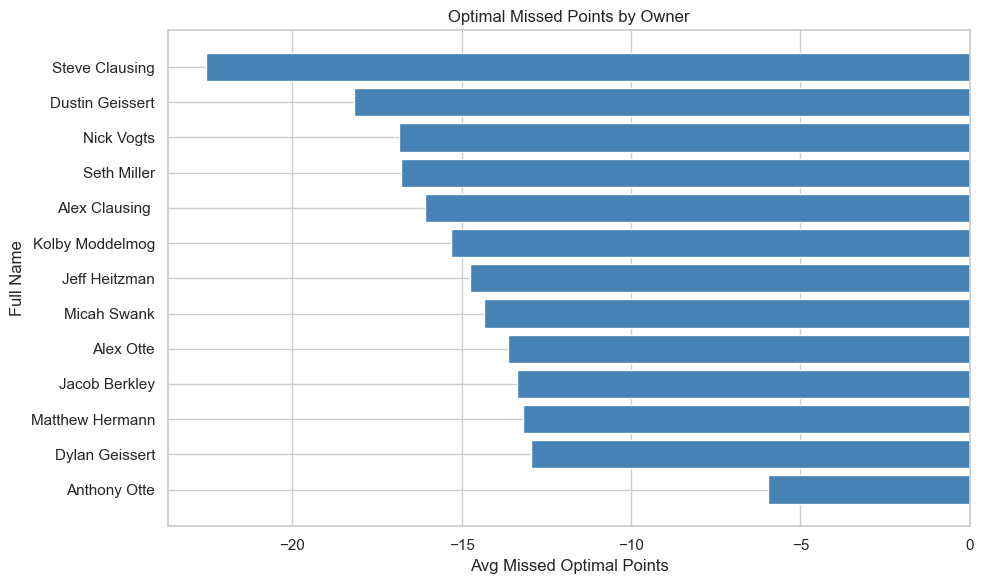

In [292]:
plt.figure(figsize=(10, 6))
plt.barh(df_Avg_Missed_Optimal['Full Name'], df_Avg_Missed_Optimal['Optimal_Missed_Pts'], color='steelblue')
plt.xlabel('Avg Missed Optimal Points')
plt.ylabel('Full Name')
plt.title('Optimal Missed Points by Owner')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()

# Show plot
plt.show()

In [293]:
df_opts_season =df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name','Year'])["Optimal_Missed_Pts"].mean().reset_index().sort_values(by='Optimal_Missed_Pts',ascending=False)


In [294]:
df_opts_wins = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)


In [295]:

df_Opts_Wins_Yrs = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name']).agg({
    'Opts': 'sum',
    'Actual_Winner': 'sum',
    'Optimal_Winner': 'sum',
    'Year': 'nunique',
    'Matchup_ID': 'count'}).reset_index()

In [296]:
df_Opts_Wins_Yrs['Opts/gm'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Matchup_ID']).round(1)
df_Opts_Wins_Yrs['Opts/yr'] = (df_Opts_Wins_Yrs['Opts']/df_Opts_Wins_Yrs['Year']).round(1)
df_Opts_Wins_Yrs['Wins/yr'] = (df_Opts_Wins_Yrs['Actual_Winner']/df_Opts_Wins_Yrs['Year']).round(1)

## Compare Average Optimal Points by Average Wins per Year

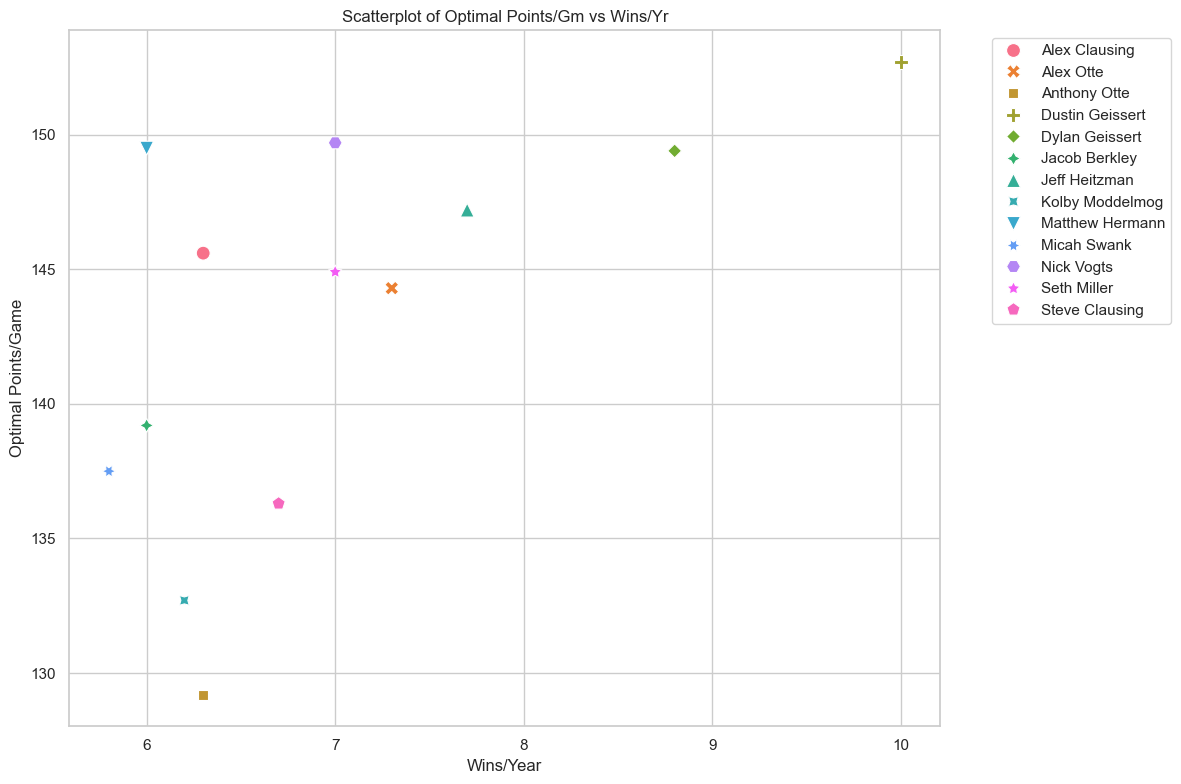

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_Opts_Wins_Yrs, x='Wins/yr', y='Opts/gm', hue='Full Name', style='Full Name', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points/Gm vs Wins/Yr')
plt.xlabel('Wins/Year')
plt.ylabel('Optimal Points/Game')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [298]:
df_opts_wins = df_matchups_1.loc[df_matchups_1['Type']=='Regular'].groupby(['Full Name','Year'])[["Opts",'Actual_Winner']].sum().reset_index().sort_values(by='Opts',ascending=True)



In [299]:

df_opts_wins['Name_Yr'] = df_opts_wins['Full Name']+"_"+df_opts_wins['Year'].astype("str")

## Showing where Owners Optimal Points are Falling Season to Season

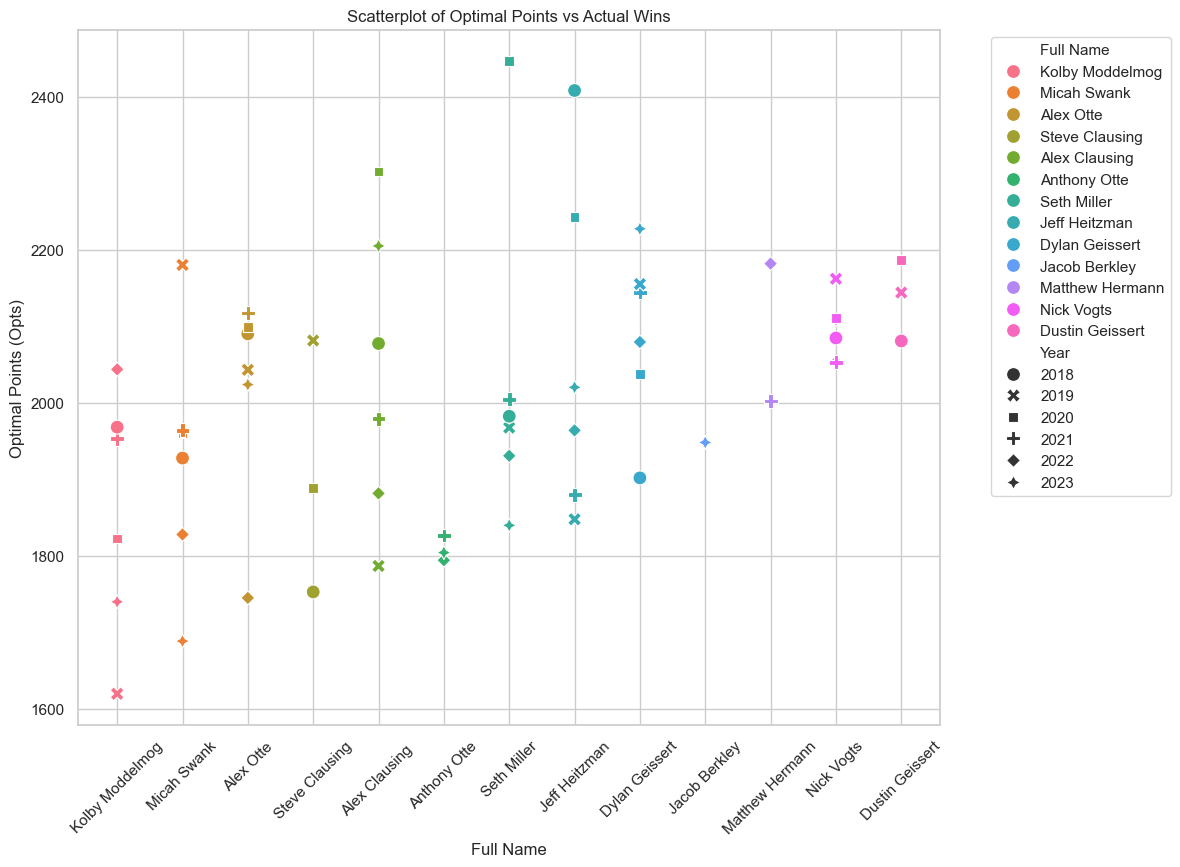

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create the scatterplot
sns.scatterplot(data=df_opts_wins, x='Full Name', y='Opts', hue='Full Name', style='Year', s=100)

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Actual Wins')
plt.xlabel('Full Name')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()


In [301]:
#df_matchups_2

In [302]:
df_matchup_stats = df_matchups_2.loc[df_matchups_2['Type']=='Regular'].groupby(['Full Name',"Year"]).agg({
    'Optimal_Missed_Pts': 'sum',
    'Opts': 'sum',
    'Apts': 'sum',
    'Opponent_Opts': 'sum',
    'Opponent_Apts': 'sum',
    'Actual_Winner': 'sum',
    'Optimal_Winner': 'sum',
    'ESPN_Winner': 'sum',
    'Matchup_ID': 'count'}).reset_index()

In [303]:

df_matchup_stats['Adjusted_Wins'] = df_matchup_stats['Optimal_Winner']-df_matchup_stats['Actual_Winner']

In [304]:

df_matchup_stats['Name_Year'] = df_matchup_stats['Full Name'] + ' ' + df_matchup_stats['Year'].astype(str)

In [305]:

df_matchup_stats.sort_values(by='Adjusted_Wins', inplace=True)

In [306]:
df_mstats_short = df_matchup_stats.loc[(df_matchup_stats['Adjusted_Wins']>1)|(df_matchup_stats['Adjusted_Wins']< -1)]


In [307]:
#df_matchup_stats

# Wins Adjusted

##### This is taking the scenario of optimal points by each team throughout the season. How would wins be adjusted? Plus wins means you missed out on wins. Minus means you gathered more wins

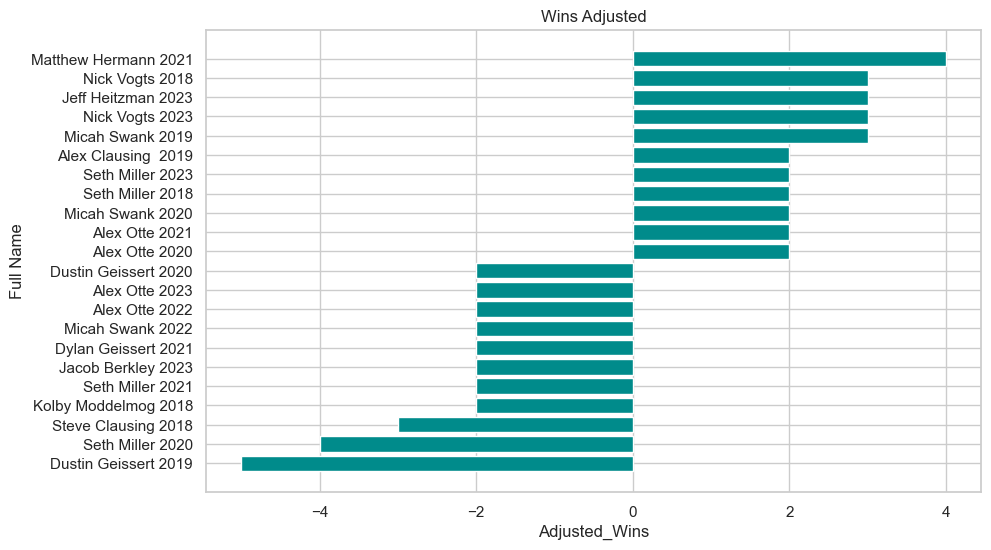

In [308]:
plt.figure(figsize=(10, 6))
plt.barh(df_mstats_short['Name_Year'], df_mstats_short['Adjusted_Wins'], color='darkcyan')
plt.xlabel('Adjusted_Wins')
plt.ylabel('Full Name')
plt.title('Wins Adjusted')
#plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
#plt.tight_layout()

# Show plot
plt.show()

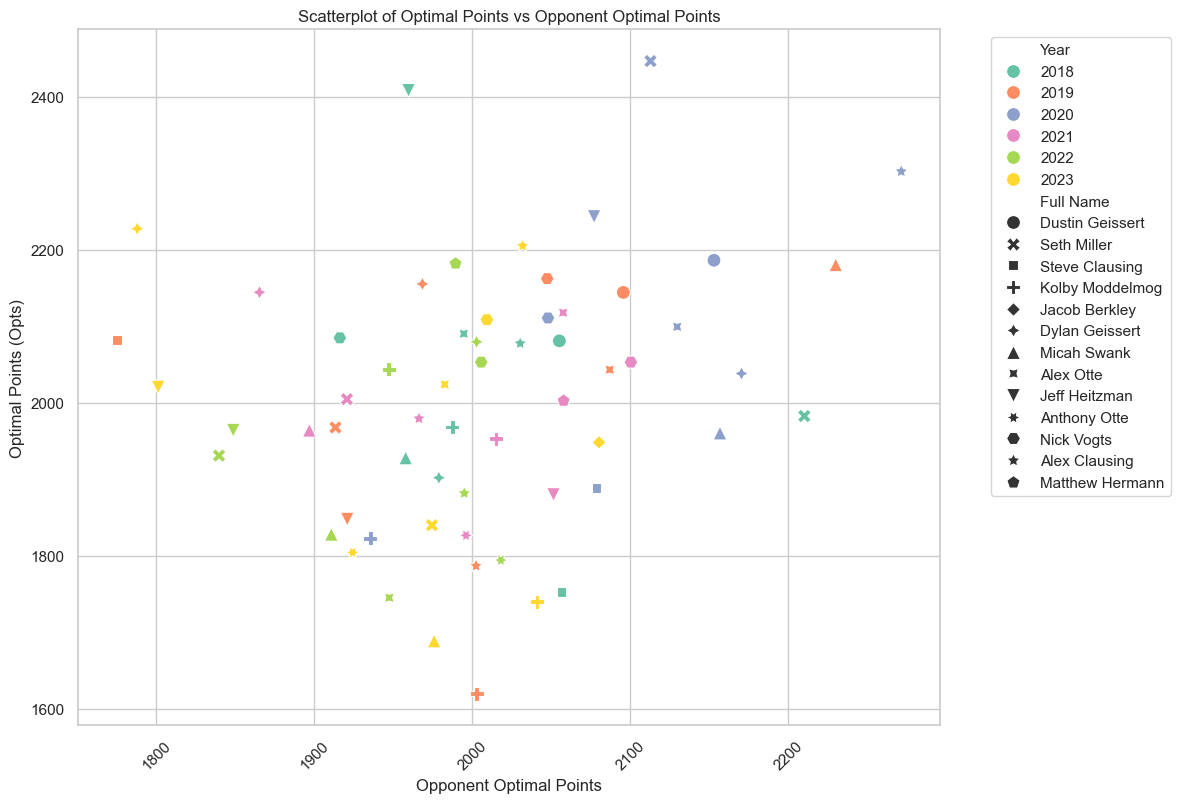

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Opponent_Opts', y='Opts', hue='Year', style='Full Name', s=100, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Opponent Optimal Points')
plt.xlabel('Opponent Optimal Points')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [310]:
df_matchup_stats['Year'] = df_matchup_stats['Year'].astype("str")

In [311]:
yearly_avg = df_matchup_stats.groupby('Year')['Opponent_Opts'].mean().reset_index().rename(columns={'Opponent_Opts': 'Yearly_Avg_Opponent_Opts'})

In [312]:
df_matchup_stats = df_matchup_stats.merge(yearly_avg, on='Year')

In [313]:
df_matchup_stats['Diff_Opponent_Opts'] = df_matchup_stats['Opponent_Opts'] - df_matchup_stats['Yearly_Avg_Opponent_Opts']

# Optimal Points vs SoS (Optimal Points by Opponents compared to Season Average)

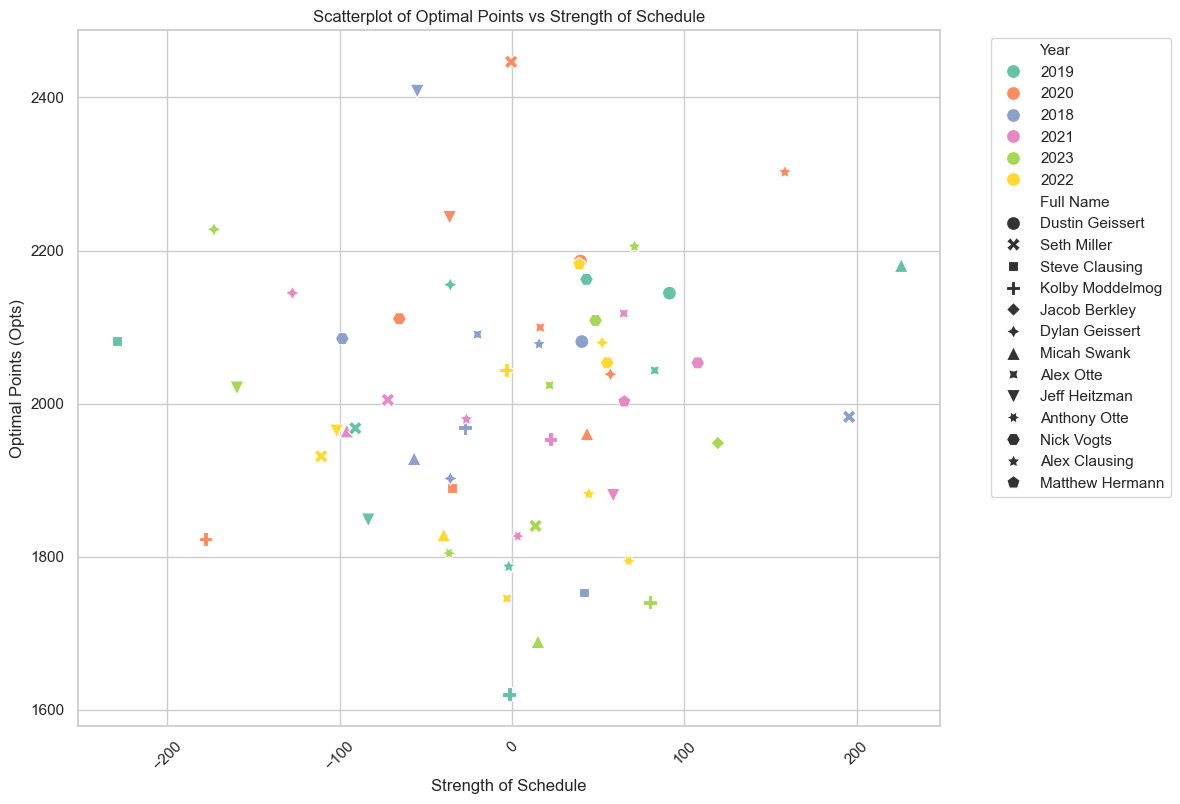

In [315]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Diff_Opponent_Opts', y='Opts', hue='Year', style='Full Name', s=100, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Strength of Schedule')
plt.xlabel('Strength of Schedule')
plt.ylabel('Optimal Points (Opts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [316]:
df_matchup_stats['Extra_Pts_Against/Game'] = df_matchup_stats['Diff_Opponent_Opts']/df_matchup_stats['Matchup_ID']

In [317]:
df_SoS = df_matchup_stats.groupby(['Full Name'])['Diff_Opponent_Opts'].sum().reset_index().sort_values(by='Diff_Opponent_Opts')

In [318]:
df_SoS_Yrs = df_Opts_Wins_Yrs.merge(df_SoS)

In [319]:
df_SoS_Yrs['Extra_Pts_Against/Game'] = df_SoS_Yrs['Diff_Opponent_Opts']/df_SoS_Yrs['Matchup_ID']

In [320]:
#df_matchup_stats

In [322]:
#df_SoS_Yrs.loc[df_SoS_Yrs['Full Name']!='Jacob Berkley']

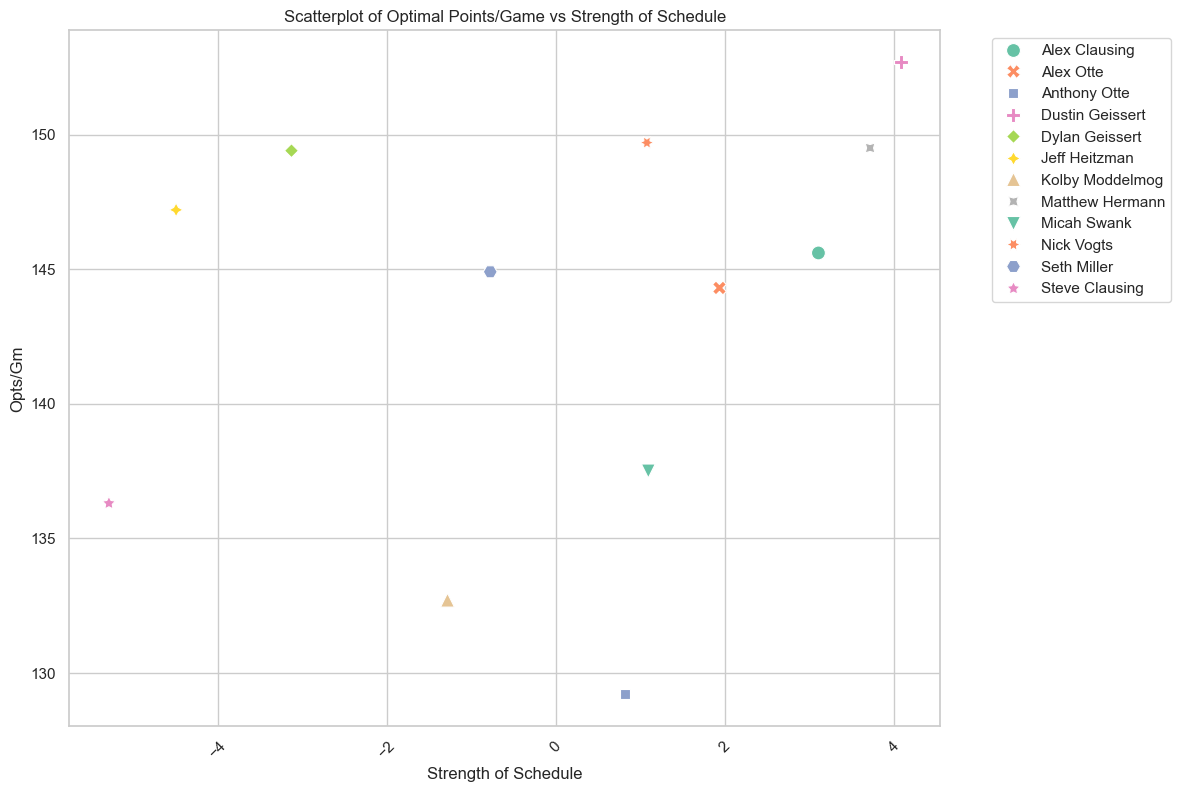

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
#sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_SoS_Yrs.loc[df_SoS_Yrs['Full Name']!='Jacob Berkley'], x='Extra_Pts_Against/Game', y='Opts/gm', hue='Full Name', style='Full Name', s=100, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Optimal Points/Game vs Strength of Schedule')
plt.xlabel('Strength of Schedule')
plt.ylabel('Opts/Gm')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [311]:
df_SoS_Yrs['Win_Percentage'] = ((df_SoS_Yrs['Actual_Winner']/df_SoS_Yrs['Matchup_ID'])*100).round(2)
df_SoS_Yrs['Optimal_Win_Percentage'] = ((df_SoS_Yrs['Optimal_Winner']/df_SoS_Yrs['Matchup_ID'])*100).round(2)

In [312]:
df_SoS_Yrs

,Full Name,Opts,Actual_Winner,Optimal_Winner,Year,Matchup_ID,Opts/gm,Opts/yr,Wins/yr,Diff_Opponent_Opts,Extra_Pts_Against/Game,Win_Percentage,Optimal_Win_Percentage
0,Alex Clausing,12233.7,38,40,6,84,145.6,2039.0,6.3,260.99,3.107024,45.24,47.62
1,Alex Otte,12120.1,44,44,6,84,144.3,2020.0,7.3,162.59,1.935595,52.38,52.38
2,Anthony Otte,5425.8,19,17,3,42,129.2,1808.6,6.3,34.42,0.819524,45.24,40.48
3,Dustin Geissert,6411.6,30,22,3,42,152.7,2137.2,10.0,171.47,4.082619,71.43,52.38
4,Dylan Geissert,12547.6,53,51,6,84,149.4,2091.3,8.8,-262.81,-3.128690,63.10,60.71
5,Jacob Berkley,1948.4,6,4,1,14,139.2,1948.4,6.0,119.41,8.529286,42.86,28.57
6,Jeff Heitzman,12364.5,46,49,6,84,147.2,2060.8,7.7,-377.51,-4.494167,54.76,58.33
7,Kolby Moddelmog,11148.7,37,34,6,84,132.7,1858.1,6.2,-107.71,-1.282262,44.05,40.48
8,Matthew Hermann,4184.9,12,16,2,28,149.5,2092.4,6.0,104.11,3.718214,42.86,57.14
9,Micah Swank,11550.1,35,38,6,84,137.5,1925.0,5.8,91.89,1.093929,41.67,45.24


# How Different would things be if everyone played their best players?

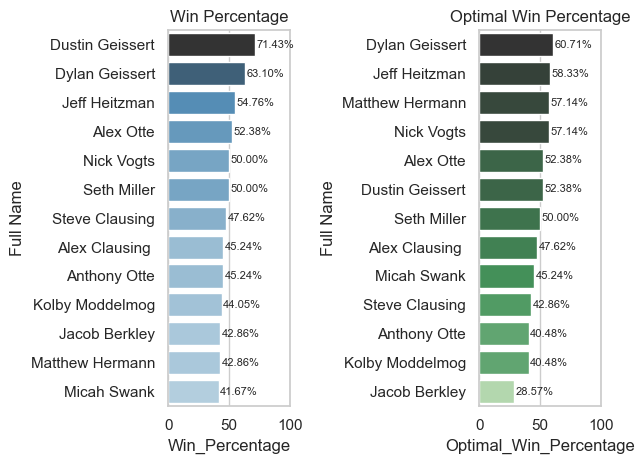

In [332]:
# Create the first subplot for Win Percentage
plt.subplot(1, 2, 1)
sns.barplot(x='Win_Percentage', y='Full Name', data=df_SoS_Yrs.sort_values(by="Win_Percentage",ascending=False), palette='Blues_d',hue='Win_Percentage',legend=False)
plt.title('Win Percentage')

plt.xlim(0, 100)

# Add percentage labels on the bars
for index, value in enumerate(df_SoS_Yrs.sort_values(by="Win_Percentage",ascending=False)['Win_Percentage']):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=8)

# Create the second subplot for Optimal Win Percentage
plt.subplot(1, 2, 2)
sns.barplot(x='Optimal_Win_Percentage', y='Full Name', data=df_SoS_Yrs.sort_values(by="Optimal_Win_Percentage",ascending=False), palette='Greens_d',hue='Optimal_Win_Percentage',legend=False)
plt.title('Optimal Win Percentage')

plt.xlim(0, 100)

# Add percentage labels on the bars
for index, value in enumerate(df_SoS_Yrs.sort_values(by="Optimal_Win_Percentage",ascending=False)['Optimal_Win_Percentage']):
    plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=8)


# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()

In [333]:
df_matchup_stats['Opponenet Realized Pts %'] = ((df_matchup_stats['Opponent_Apts']/df_matchup_stats['Opponent_Opts'])*100).round(2)

In [334]:
df_matchup_stats['Realized Pts %'] = ((df_matchup_stats['Apts']/df_matchup_stats['Opts'])*100).round(2)

In [335]:
#df_matchup_stats

# Optimal Points vs Realized 

#### Could things have been different?

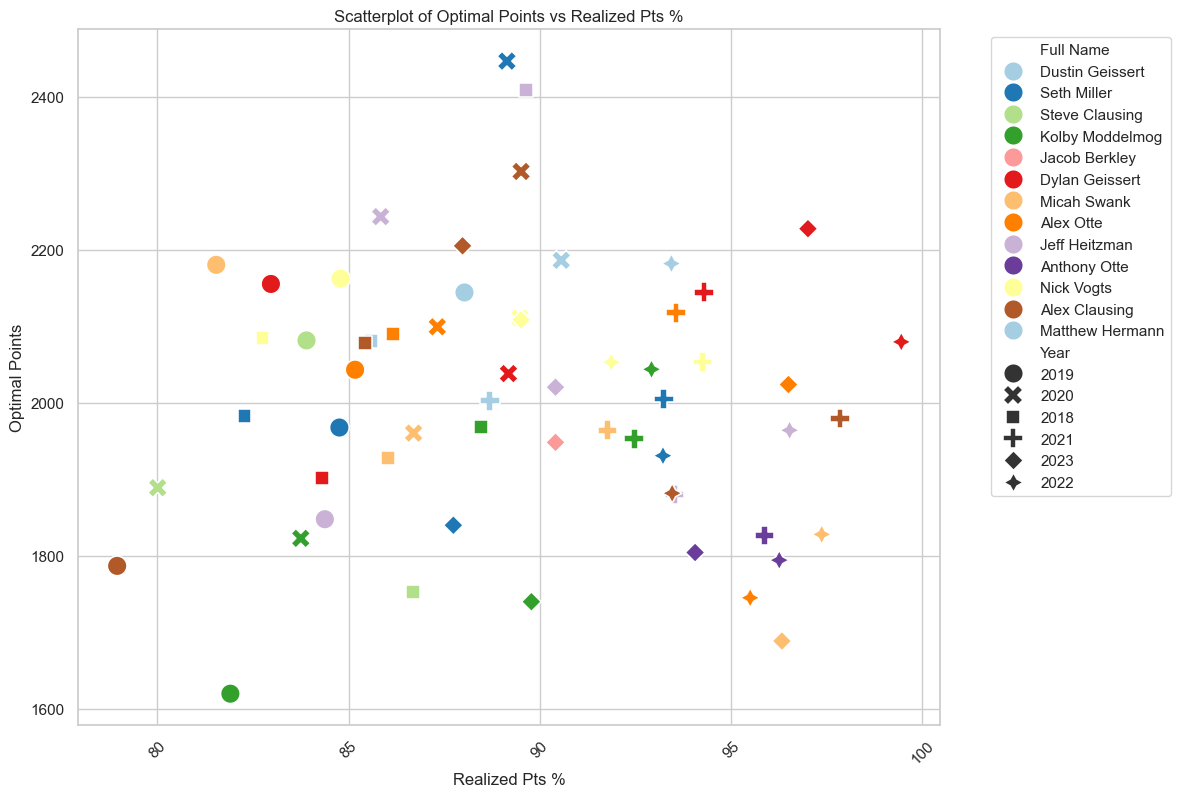

In [336]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.set_palette("Paired",14)

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Realized Pts %', y='Opts', hue='Full Name', style='Year', s=200)

# Add titles and labels
plt.title('Scatterplot of Optimal Points vs Realized Pts %')
plt.xlabel('Realized Pts %')
plt.ylabel('Optimal Points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

## Were you lucky with the opponents you faced not reaching their optimal points?


##### Not much to look at here for my league? The change in format muddled the data

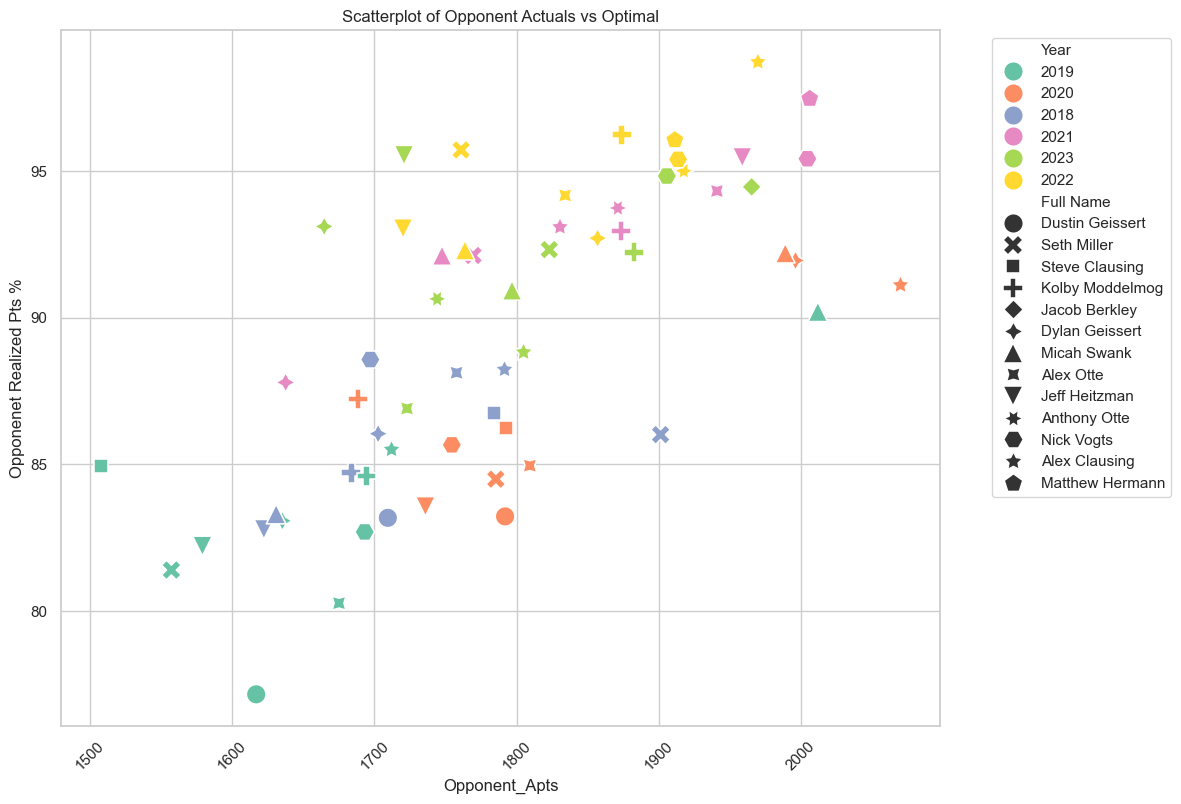

In [338]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=df_matchup_stats, x='Opponent_Apts', y='Opponenet Realized Pts %', hue='Year', style='Full Name', s=200, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Opponent Actuals vs Optimal')
plt.xlabel('Opponent_Apts')
plt.ylabel('Opponenet Realized Pts %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [339]:
df_pts_med = df_pts.groupby(['Year'])[['Opts','Apts']].median().reset_index().rename(columns={'Opts':'Opts_Lg','Apts':'Apts_Lg'})

In [340]:
df_pts_avg = df_pts.groupby(['Year','TeamID'])[['Opts','Apts']].mean().reset_index()

In [341]:
df_pts1 = df_pts_avg.merge(df_pts_med)

In [342]:
#Potential Reached

df_pts1['Optimized %'] = df_pts1['Apts']/df_pts1['Opts']
df_pts1['League OPT %'] = df_pts1['Apts_Lg']/df_pts1['Opts_Lg']

In [343]:
#Optiamal Points+
df_pts1['Opts+'] = (df_pts1['Opts']/df_pts1['Opts_Lg'])*100
df_pts1['Optimized+'] = (df_pts1['Optimized %']/df_pts1['League OPT %'])*100

In [344]:
df_pts2 = df_pts1.merge(tm_owners)

In [345]:
df_pts2['First'] = df_pts2['First'].str.capitalize()
df_pts2['Last'] = df_pts2['Last'].str.capitalize()

In [346]:
df_pts2.drop_duplicates(inplace=True)

In [347]:
df_pts2['Full Name'] = df_pts2['First'] + " "+ df_pts2['Last']

In [348]:

df_pts3 = df_pts2.loc[df_pts2['Full Name']!='Dave Miller']

In [349]:

df_pts3.loc[df_pts3['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
df_pts3.loc[df_pts3['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [350]:
df_optimized = df_pts3.groupby(['Full Name'])[['Opts+','Optimized+']].mean().reset_index()

# Best Owner


### Who is fielding the teams with the most optimal points
### Over 100 is over average.

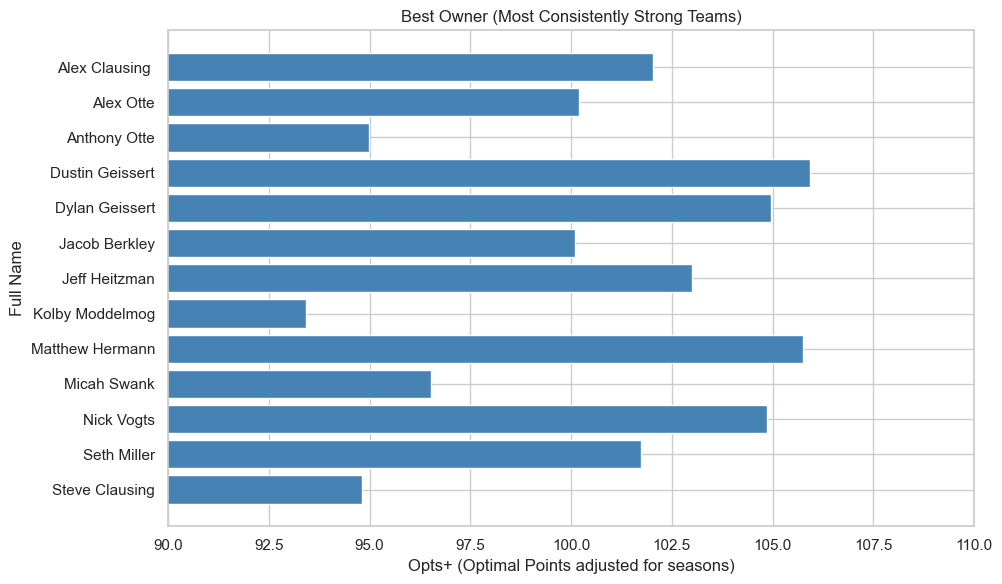

In [352]:
plt.figure(figsize=(10, 6))
plt.barh(df_optimized['Full Name'], df_optimized['Opts+'], color='steelblue')
plt.xlabel('Opts+ (Optimal Points adjusted for seasons)')
plt.ylabel('Full Name')
plt.title('Best Owner (Most Consistently Strong Teams)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the largest values at the top
plt.tight_layout()
# Use the current axis object to set the x-axis limits
ax = plt.gca()
ax.set_xlim(90, 110) 
# Show plot
plt.show()

In [353]:
df_pts_reg = df_pts.loc[((df_pts['Week']<15)&(df_pts['Year']>=2021))|((df_pts['Week']<14)&(df_pts['Year']<=2020))]

In [354]:
wk_pts_med = df_pts_reg.groupby(['Year','Week'])[['Opts','Apts']].median().reset_index().rename(columns={'Opts':'Opts_Lg','Apts':'Apts_Lg'})

In [355]:
wk_pts_avg = df_pts_reg.groupby(['Year','TeamID','Week'])[['Opts','Apts']].mean().reset_index()

In [356]:
wk_pts1 = wk_pts_avg.merge(wk_pts_med)

In [357]:
wk_pts1 = wk_pts1.merge(tm_owners)

In [358]:
wk_pts1['First'] = wk_pts1['First'].str.capitalize()
wk_pts1['Last'] = wk_pts1['Last'].str.capitalize()
wk_pts1.drop_duplicates(inplace=True)
wk_pts1['Full Name'] = wk_pts1['First'] + " "+ wk_pts1['Last']
wk_pts2 = wk_pts1.loc[wk_pts1['Full Name']!='Dave Miller']

wk_pts2.loc[wk_pts2['Full Name']=='Nick  Vgts','Full Name']="Nick Vogts"
wk_pts2.loc[wk_pts2['Full Name']=='Nick Vgts','Full Name']="Nick Vogts"

In [359]:
wk_ptsH = wk_pts2.merge(df_sch, left_on=['Year','TeamID','Week'], right_on=['Year','HomeTeamId','Week'])

In [360]:
wk_ptsA = wk_pts2.merge(df_sch, left_on=['Year','TeamID','Week'], right_on=['Year','AwayTeamId','Week'])

In [361]:
wk_ptsH1 = wk_ptsA[['Year', 'TeamID','Full Name', 'Week', 'Opts', 'Apts', 'Opts_Lg', 'Apts_Lg',
       'HomeTeamId', 'HomeTotalPoints',
       'Type', 'Matchup_ID']].rename(columns={ 'HomeTeamId':'OppID', 'HomeTotalPoints':'OppApts'})

In [362]:
wk_ptsA1 = wk_ptsH[['Year', 'TeamID','Full Name', 'Week', 'Opts', 'Apts', 'Opts_Lg', 'Apts_Lg', 'AwayTeamId', 'AwayTotalPoints',
       'Type', 'Matchup_ID']].rename(columns={ 'AwayTeamId':'OppID', 'AwayTotalPoints':'OppApts'})

In [363]:
wk_pts_opp = pd.concat([wk_ptsA1,wk_ptsH1])

In [364]:
wk_pts_opp['PoorOpp']=0
wk_pts_opp['LuckyWin']=0
wk_pts_opp['UnluckyLoss']=0

wk_pts_opp.loc[wk_pts_opp['OppApts']<wk_pts_opp['Apts_Lg'],'PoorOpp']=1
wk_pts_opp.loc[(wk_pts_opp['OppApts']<wk_pts_opp['Apts_Lg'])&(wk_pts_opp['Apts']<wk_pts_opp['Apts_Lg'])&(wk_pts_opp['Apts']>wk_pts_opp['OppApts']),'LuckyWin']=1
wk_pts_opp.loc[(wk_pts_opp['OppApts']>wk_pts_opp['Apts_Lg'])&(wk_pts_opp['Apts']>wk_pts_opp['Apts_Lg'])&(wk_pts_opp['Apts']<wk_pts_opp['OppApts']),'UnluckyLoss']=1

In [365]:
yr_opp = wk_pts_opp.groupby(['Full Name','Year'])[['PoorOpp','LuckyWin','UnluckyLoss']].sum().reset_index()

In [366]:
yr_opp['LuckFactor'] = yr_opp['LuckyWin']-yr_opp['UnluckyLoss']

In [367]:
yr_opp['PoorOpp_LgAvg'] = yr_opp['PoorOpp'].mean().round(1)
yr_opp['LuckyWin_LgAvg'] = yr_opp['LuckyWin'].mean().round(1)
yr_opp['UnluckyLoss_LgAvg'] = yr_opp['UnluckyLoss'].mean().round(1)
yr_opp['LuckFactor_LgAvg'] = yr_opp['LuckFactor'].mean().round(1)

# CRAZY STAT

In [368]:
yr_opp['UnluckyLoss'].sum()

95

In [369]:
yr_opp['LuckyWin'].sum()

96

In [370]:
yr_opp['PoorOpp+'] = (yr_opp['PoorOpp']/yr_opp['PoorOpp_LgAvg'])*100
yr_opp['LuckyWin+'] = (yr_opp['LuckyWin']/yr_opp['LuckyWin_LgAvg'])*100
yr_opp['UnluckyLoss+'] = (yr_opp['UnluckyLoss']/yr_opp['UnluckyLoss_LgAvg'])*100


# Have you been lucky?

#### How many poor opponents did you face? (Opponents Scoring Under Median in a particular week)
#### How did your luck fair? (Difference between LuckyWins and UnluckyLoss) Positive is Favorable Luck

##### LuckyWin = Under Median Points Scored by you with a win
##### UnluckyLoss = Over Median Points Scored but with a loss

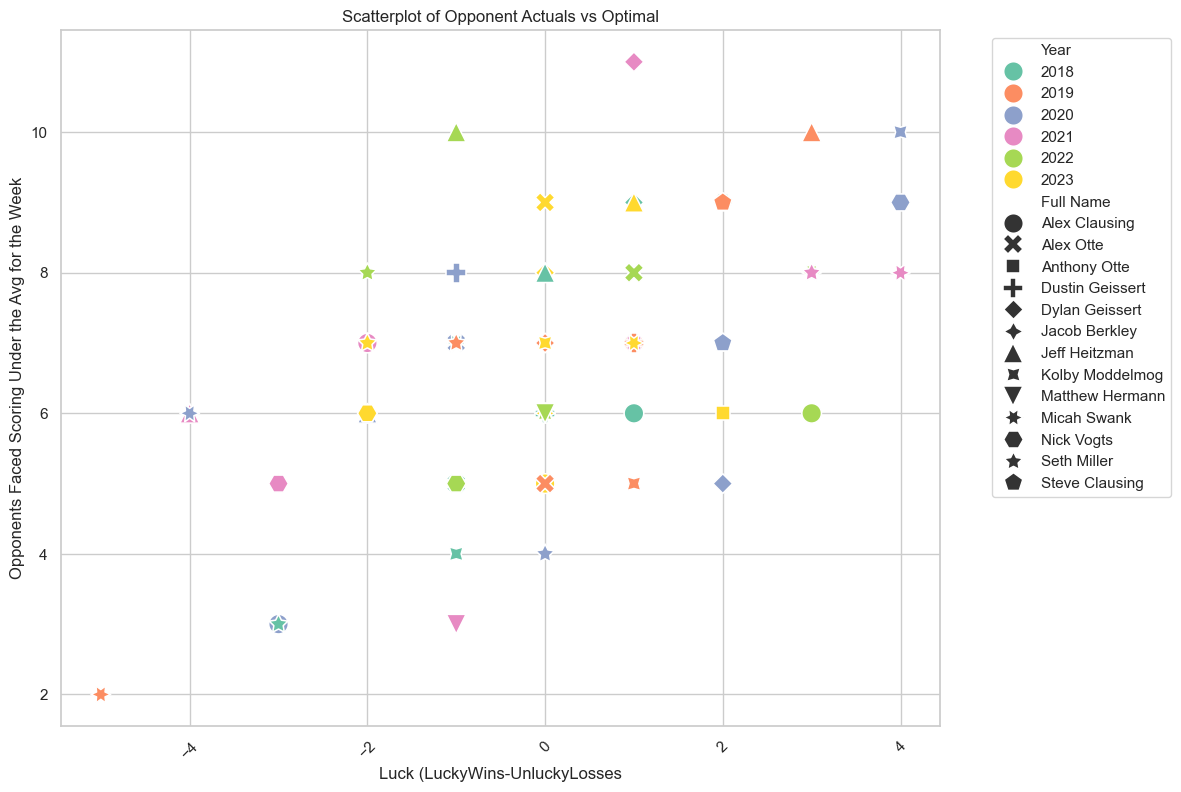

In [372]:
# Set the figure size and style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.set_palette("dark")

# Create the scatterplot
sns.scatterplot(data=yr_opp, x='LuckFactor', y='PoorOpp', hue='Year', style='Full Name', s=200, palette='Set2')

# Add titles and labels
plt.title('Scatterplot of Opponent Actuals vs Optimal')
plt.xlabel('Luck (LuckyWins-UnluckyLosses')
plt.ylabel('Opponents Faced Scoring Under the Avg for the Week')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.xticks(rotation=45)


# Display the plot
plt.show()

In [373]:
ovr_details = yr_opp.groupby('Full Name')[['PoorOpp','LuckyWin','UnluckyLoss','LuckFactor']].sum().reset_index().merge(df_Opts_Wins_Yrs)

In [374]:
ovr_details['PoorOpp_rate'] = ((ovr_details['PoorOpp']/ovr_details['Matchup_ID'])*100).round(2)
ovr_details['LuckyWin_rate'] = ((ovr_details['LuckyWin']/ovr_details['Matchup_ID'])*100).round(2)
ovr_details['UnluckyLoss_rate'] = ((ovr_details['UnluckyLoss']/ovr_details['Matchup_ID'])*100).round(2)

In [375]:
ovr_details[['Full Name', 'PoorOpp', 'LuckyWin', 'UnluckyLoss', 'LuckFactor', 'Year', 'Matchup_ID', 'Opts/gm',
       'Opts/yr', 'Wins/yr', 'PoorOpp_rate', 'LuckyWin_rate',
       'UnluckyLoss_rate']]

,Full Name,PoorOpp,LuckyWin,UnluckyLoss,LuckFactor,Year,Matchup_ID,Opts/gm,Opts/yr,Wins/yr,PoorOpp_rate,LuckyWin_rate,UnluckyLoss_rate
0,Alex Clausing,34,9,9,0,6,84,145.6,2039.0,6.3,40.48,10.71,10.71
1,Alex Otte,42,7,7,0,6,84,144.3,2020.0,7.3,50.00,8.33,8.33
2,Anthony Otte,20,6,3,3,3,42,129.2,1808.6,6.3,47.62,14.29,7.14
3,Dustin Geissert,21,5,5,0,3,42,152.7,2137.2,10.0,50.00,11.90,11.90
4,Dylan Geissert,45,8,7,1,6,84,149.4,2091.3,8.8,53.57,9.52,8.33
5,Jacob Berkley,6,1,1,0,1,14,139.2,1948.4,6.0,42.86,7.14,7.14
6,Jeff Heitzman,49,9,12,-3,6,84,147.2,2060.8,7.7,58.33,10.71,14.29
7,Kolby Moddelmog,38,12,8,4,6,84,132.7,1858.1,6.2,45.24,14.29,9.52
8,Matthew Hermann,9,3,4,-1,2,28,149.5,2092.4,6.0,32.14,10.71,14.29
9,Micah Swank,38,12,14,-2,6,84,137.5,1925.0,5.8,45.24,14.29,16.67
